# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
import torch


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

print(env_info)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Define the Function to Perform the Reinforcement Learning
A checkpoint is saved as checkpoint13.pth when the agent achieves a score of 13 averaged over 100 episodes.

In [5]:
def dqn(
    agent,
    n_episodes=2000,
    max_t=100000,
    epsilon_initial = 1.0,
    epsilon_final = 0.01,
    epsilon_rate = 0.005,
    gamma_initial = 0.9,
    gamma_final = 0.99,
    gamma_rate = 0.002,
    beta_initial = 0.4,
    beta_rate = 0.002,
    tau_initial = 0.001,
    tau_final = 0.1,
    tau_rate = 0.00001
    ):
    """
    Deep Q-Learning.
    n_episodes (int): Maximum number of training episodes
    max_t (int): Maximum number of timesteps per episode
    epsilon_initial (float): Initial value of epsilon for epsilon-greedy selection of an action
    epsilon_final (float): Final value of epsilon
    epsilon_rate (float): A rate (0.0 to 1.0) for decreasing epsilon for each episode. Higher is faster decay.
    gamma_initial (float): Initial gamma discount factor (0 to 1). Higher values favor long term over current rewards.
    gamma_final (float): Final gamma discount factor (0 to 1).
    gammma_rate (float): A rate (0 to 1) for increasing gamma.
    beta_initial (float): For prioritized replay. Corrects bias induced by weighted sampling of stored experiences.
        The beta parameters have no effect if the agent has prioritized experience replay activated.
    beta_rate (float): Rate (0 to 1) for increasing beta to 1 as per Schauel et al. https://arxiv.org/abs/1511.05952
    tau_initial (float): Initial value for tau, the weighting factor for soft updating the neural network.
        The tau parameters have no effect if the agent uses fixed Q targets instead of soft updating.
    tau_final (float): Final value of tau.
    tau_rate (float): Rate (0 to 1) for increasing tau each episode.
    
    """
    # List of scores for an episode
    scores = []
    
    # Most recent 100 scores
    scores_window = deque(maxlen=100)
    
    epsilon = epsilon_initial
    epsilon_scale = 1.0 - epsilon_rate
 
    # Set final gamma to the value suggested for prioritized replay in
    # Schaul et al., Prioritized Replay, ICLR 2016, https://arxiv.org/abs/1511.05952
    #gamma_final = 1.0 - 1.0 / state_size
    gamma = gamma_initial
    gamma_scale = 1.0 - gamma_rate
    
    beta = beta_initial
    beta_scale = 1.0 - beta_rate
    
    tau = tau_initial
    tau_scale = 1.0 - tau_rate
    
    count = 0
    level1 = False
    for i_episode in range(1, n_episodes+1):
        # Reset environment
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Get next state
        state = env_info.vector_observations[0]

        t = 0
        score = 0
        while True:
            count += 1
            t += 1
            
            # Get action
            action = agent.act(state, epsilon)
            
            # Send action to environment
            env_info = env.step(action.astype(np.int32))[brain_name]
            
            # Get next state
            next_state = env_info.vector_observations[0]
                                                      
            # Get reward
            reward = env_info.rewards[0]
            
            # Check is episode finished
            done = env_info.local_done[0]
                                                                                     
            agent.step(state, action, reward, next_state, done, gamma, beta, tau)
            score += reward
            state = next_state
            
            # Exit if episode finished
            if done or t > max_t:
                break
                
        scores_window.append(score)
        scores.append(score)
                                                      
        # Decrease epsilon. Limit to epsilon_final.       
        #epsilon = max(epsilon_final, epsilon_scale * epsilon)
        epsilon = epsilon_final + epsilon_scale * (epsilon - epsilon_final)

        # Increase gamma discount factor. Limit to gamma_final.
        gamma = gamma_final - gamma_scale * (gamma_final - gamma)
        
        # Increase beta for prioritized experience replay. Gradually increases to 1.
        if agent.prioritized_replay:
            beta = 1.0 - beta_scale * (1.0 - beta)
        
        tau = tau_final - tau_scale * (tau_final - tau)
        
        print('\rEpisode {}\tAverage Score: {:.4f}\tepsilon: {:.4f}\tgamma: {:.4f}\tbeta: {:.4f}\ttau: {:.4f}'
              .format(i_episode, np.mean(scores_window), epsilon, gamma, beta, tau), end="")
        if i_episode % scores_window.maxlen == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            if not level1 and np.mean(scores_window) > 13:
                level1 = True
                print('\rPassing score achieved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint13.pth')
            if level1 and np.mean(scores_window) > 80:
                print('\rAverage score > 80 achieved in {:d} episodes!\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
                torch.save(agent.qnetwork_local.state_dict(), 'checkpoint80.pth')
                break

    return scores


### 4. Declare the Learning Agent
Agent has the following parameters:

    state_size: Number of possible states in the environment
    action_size: Number of possible actions
    seed: For random number generation
    target_update_interval (int): Interval for updating the neural network weights for fixed Q targets.
        Set to a negative number to use soft updating instead. Default -1.
    batch_normalize (boolean): Default False. True if batch normalization is used in the neural network
    error_clipping (boolean): Default False. Set to True to limit the time difference error to between -1 and 1
    reward_clipping (boolean): Default False. Set to True to limit the reward to betwen -1 and 1
    gradient_clipping (boolean): Default False. Set to True to limit the size of the gradients to between -1 and 1
    double_dqn (boolean): Default True. Flag to use double Q learning
    dueling_dqn (boolean): Default True. Flag to use dueling Q networks
    prioritized_replay (boolean): Default False. Flag for prioritized experience replay
    learning_rate (float): initial learning rate

In [6]:
from collections import deque
from dqn_agent import Agent, load_and_run_agent

agent = Agent(
    state_size=state_size,
    action_size=action_size,
    seed=0,
    batch_normalize = False,
    error_clipping = False,
    reward_clipping = False,
    gradient_clipping = False,
    double_dqn = True,
    prioritized_replay = True,
    dueling_dqn = True,
    learning_rate = 0.0005
)

cuda:0


### 5. Train the Learning Agent
The resulting scores are stored and plotted.

Episode 100	Average Score: 1.0900	epsilon: 0.6097	gamma: 0.9571	beta: 0.6365	tau: 0.0011
Episode 200	Average Score: 4.4400	epsilon: 0.3733	gamma: 0.9779	beta: 0.7798	tau: 0.0012
Episode 300	Average Score: 7.1700	epsilon: 0.2301	gamma: 0.9856	beta: 0.8666	tau: 0.0013
Episode 400	Average Score: 9.4200	epsilon: 0.1433	gamma: 0.9884	beta: 0.9192	tau: 0.0014
Episode 500	Average Score: 12.3500	epsilon: 0.0908	gamma: 0.9894	beta: 0.9511	tau: 0.0015
Episode 600	Average Score: 13.7800	epsilon: 0.0589	gamma: 0.9898	beta: 0.9704	tau: 0.0016
Passing score achieved in 600 episodes!	Average Score: 13.7800
Episode 700	Average Score: 14.4600	epsilon: 0.0396	gamma: 0.9899	beta: 0.9820	tau: 0.0017
Episode 800	Average Score: 15.0600	epsilon: 0.0280	gamma: 0.9900	beta: 0.9891	tau: 0.0018
Episode 900	Average Score: 14.6200	epsilon: 0.0209	gamma: 0.9900	beta: 0.9934	tau: 0.0019
Episode 1000	Average Score: 15.6900	epsilon: 0.0166	gamma: 0.9900	beta: 0.9960	tau: 0.0020
Episode 1100	Average Score: 15.1800	epsi

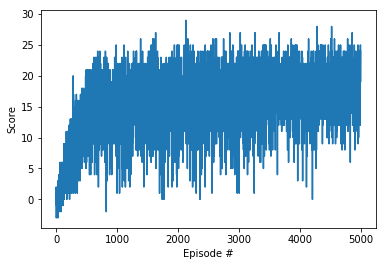

In [7]:
scores = dqn(
    agent,
    n_episodes = 5000,
    epsilon_initial = 1.0,
    epsilon_final = 0.01,
    epsilon_rate = 0.005,
    gamma_initial = 0.90,
    gamma_final = 0.99,
    gamma_rate = 0.01,
    beta_initial = 0.4,
    beta_rate = 0.005,
    tau_initial = 0.001,
    tau_final = 0.1,
    tau_rate = 0.00001
)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Save the Trained Agent
Another checkpoint is saved after all the training has been completed.

In [8]:
 torch.save(agent.qnetwork_local.state_dict(), 'checkpoint13_buffer1e6_every4_tau.pth')

### 7. Run the Trained Agent
The trained agent is run for 3 episodes and the score for each episode is printed.

In [9]:
load_and_run_agent(agent, env, 'checkpoint_final_buffer1e6_every4_tau', 100)

Score: 18.0
Score: 20.0
Score: 20.0
Score: 14.0
Score: 17.0
Score: 18.0
Score: 18.0
Score: 18.0
Score: 17.0
Score: 18.0
Score: 20.0
Score: 17.0
Score: 18.0
Score: 17.0
Score: 14.0
Score: 19.0
Score: 19.0
Score: 17.0
Score: 20.0
Score: 20.0
Score: 20.0
Score: 20.0
Score: 17.0
Score: 17.0
Score: 18.0
Score: 18.0
Score: 20.0
Score: 12.0
Score: 22.0
Score: 17.0
Score: 16.0
Score: 15.0
Score: 17.0
Score: 19.0
Score: 23.0
Score: 18.0
Score: 19.0
Score: 23.0
Score: 15.0
Score: 17.0
Score: 18.0
Score: 17.0
Score: 19.0
Score: 17.0
Score: 21.0
Score: 17.0
Score: 13.0
Score: 14.0
Score: 24.0
Score: 20.0
Score: 16.0
Score: 23.0
Score: 21.0
Score: 11.0
Score: 20.0
Score: 16.0
Score: 21.0
Score: 19.0
Score: 14.0
Score: 19.0
Score: 19.0
Score: 18.0
Score: 18.0
Score: 14.0
Score: 18.0
Score: 20.0
Score: 21.0
Score: 17.0
Score: 21.0
Score: 20.0
Score: 19.0
Score: 16.0
Score: 21.0
Score: 19.0
Score: 20.0
Score: 22.0
Score: 20.0
Score: 12.0
Score: 20.0
Score: 13.0
Score: 14.0
Score: 20.0
Score: 7.0
Score

When finished, you can close the environment.

In [10]:
env.close()